In [2]:
import sys
sys.path.append('../')
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set(style='ticks', context='paper',
                               rc={'font.size': 6, 
                                   'axes.titlesize': 7,
                                   'axes.labelsize': 7,
                                   'axes.labelpad': 2,
                                   'xtick.labelsize': 5,
                                   'ytick.labelsize': 5,
                                   'legend.fontsize' : 5.5,
                                   'legend.markerscale': 0.5,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 2.5,
                                   'ytick.major.size': 2.5,
                                   'xtick.minor.size': 1.5,
                                   'ytick.minor.size': 1.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})
from matplotlib import pyplot as plt
from plotting import annotate_corr

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}
id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

---
# Dimensionality vs. encoding performance

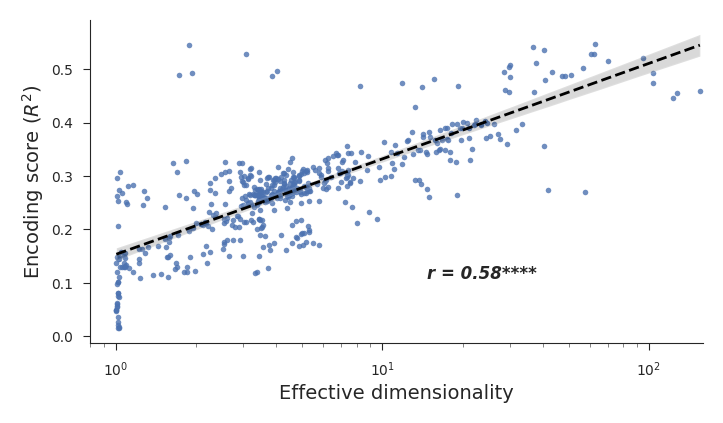

In [7]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

ax.set_xlim(0.8, 160)
sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Effective dimensionality', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='effective dimensionality', y='score', pos=(0.55, 0.2), ax=ax)

plt.savefig('saved/results_ED-vs-encoding.png', dpi=300)
plt.show()

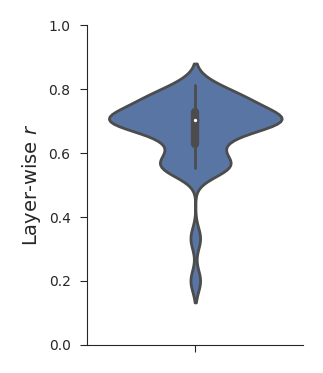

In [9]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/eigmetrics|dataset:{dataset}|pooling:True|grayscale:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r, p = stats.pearsonr(x['score'], x['effective dimensionality'])
    return pd.DataFrame({'r_score_dim': [r], 'p_score_dim': [p]})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'effective dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.5, 1.75))

sns.violinplot(data=data, y='r_score_dim', ax=ax, linewidth=1 )
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', ylim=(0, 1))

plt.savefig('saved/results_ED-vs-encoding-layerwise.png', dpi=300)
plt.show()

---
# Effect of depth

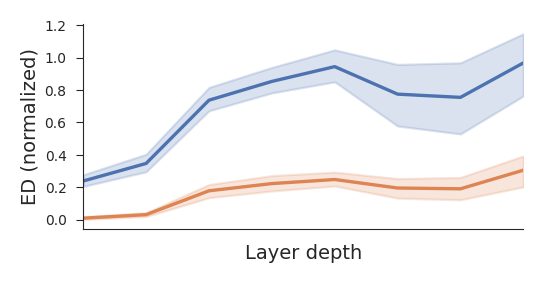

In [2]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[(data.kind != 'Untrained') & (data.architecture == 'ResNet18')]

normed_metrics = data.groupby(['architecture', 'task', 'kind', 'source'])\
                     [['between-concept dimensionality', 'within-concept dimensionality (mean)']]\
                     .apply(lambda x: (x - x.min().min()) / (x.max().max() - x.min().max()))
normed_metrics.columns = [c + ' normed' for c in normed_metrics.columns]
data = pd.concat([data, normed_metrics], axis=1)

data = data.melt(id_vars=id_columns, 
                 value_vars=['within-concept dimensionality (mean) normed', 'between-concept dimensionality normed'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(2.6, 1.3))

sns.lineplot(data=data, x='layer', y='metric_value', hue='metric', ax=ax)
ax.set(xlabel='Layer depth', ylabel='ED (normalized)', xticklabels=[], xlim=(0, 7))
ax.tick_params(axis='x', length=0)

ax.legend().remove()

plt.savefig('saved/results_depth.png', dpi=300)
plt.show()

---
# Effect of training

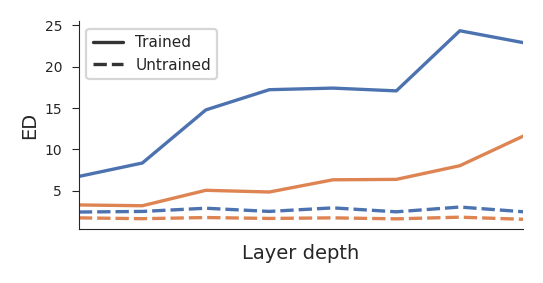

In [3]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[(data.source == 'PyTorch') & (data.architecture == 'ResNet18')]

data = data.melt(id_vars=id_columns, 
                 value_vars=['within-concept dimensionality (mean)', 'between-concept dimensionality'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(2.6, 1.3))

sns.lineplot(data=data, x='layer', y='metric_value', hue='metric', style='kind',
             style_order=['Supervised', 'Untrained'],
             ax=ax)
ax.set(xlabel='Layer depth', ylabel='ED', xticklabels=[], xlim=(0, 7))
ax.tick_params(axis='x', length=0)

handles, _ = ax.get_legend_handles_labels()
ax.legend(loc='upper left', 
          labels=['Trained', 'Untrained'], 
          handles=handles[4:6])

plt.savefig('saved/results_training.png', dpi=300)
plt.show()

---
# ED distribution

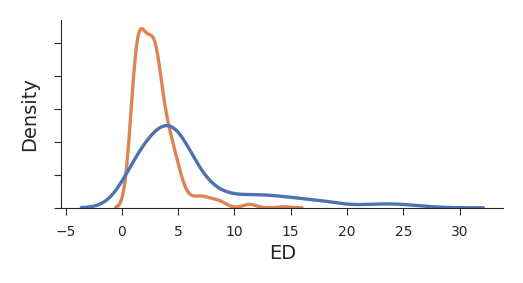

In [4]:
dataset = 'imagenet'
data = pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv')
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

data = data.melt(id_vars=id_columns, 
                 value_vars=['within-concept dimensionality (mean)', 'between-concept dimensionality'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(2.5, 1.3))

sns.kdeplot(data=data, x='metric_value', hue='metric', legend=False, ax=ax)

ax.set(xlabel='ED', ylabel='Density', yticklabels=[])

plt.savefig('saved/results_distribution.png', dpi=300)
plt.show()

---
# Classification

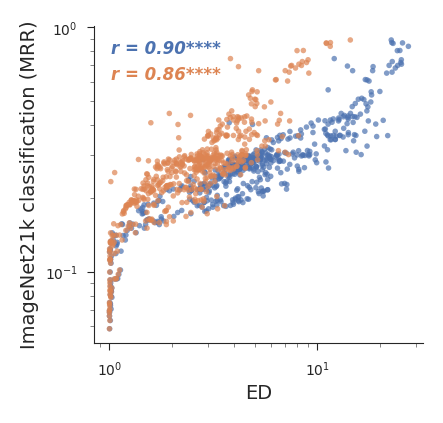

In [7]:
data = pd.read_csv(f'../../results/n-shot|dataset:imagenet21k|classifier:prototype|pooling:True.csv')
data = data[data.n_train == 50]
data = data.drop([c for c in data.columns if c not in id_columns + ['MRR']], axis='columns')
data = data.groupby(id_columns, as_index=False).mean()

dataset = 'imagenet'
data = pd.merge(data, 
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data.melt(id_vars=id_columns + ['MRR'], 
                 value_vars=['within-concept dimensionality (mean)', 'between-concept dimensionality'], 
                 var_name='metric', value_name='metric_value')

fig, ax = plt.subplots(figsize=(2.1, 2))

sns.scatterplot(data=data, x='metric_value', y='MRR', hue='metric',
                alpha=0.7, s=4, linewidth=0, ax=ax)
ax.set(xscale='log', yscale='log', xlabel='ED', ylabel='ImageNet21k classification (MRR)')
annotate_corr(data[data.metric == 'within-concept dimensionality (mean)'], 
              x='metric_value', y='MRR', ax=ax, 
              pos=(0.05, 0.91), color=sns.color_palette()[0])
annotate_corr(data[data.metric == 'between-concept dimensionality'], 
              x='metric_value', y='MRR', ax=ax, 
              pos=(0.05, 0.83), color=sns.color_palette()[1])

ax.legend().remove()

plt.savefig('saved/results_classification.png', dpi=300)
plt.show()

---
# Appendix - Dimensionality vs. encoding performance

## No spatial pooling

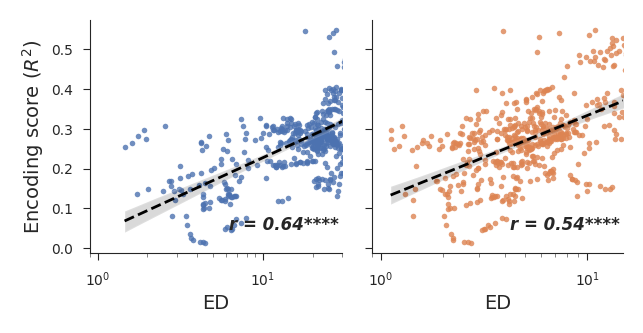

In [8]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, axs = plt.subplots(1, 2, figsize=(3.1, 1.55))

axs[0].set_xlim(0.9, 30)
sns.regplot(data=data, x='within-concept dimensionality (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[0])
axs[0].set(xlabel='ED', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='within-concept dimensionality (mean)', y='score', pos=(0.55, 0.1), ax=axs[0])

axs[1].set_xlim(0.9, 15)
sns.regplot(data=data, x='between-concept dimensionality', y='score', 
            logx=True, color=sns.color_palette()[1],
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[1])
axs[1].set(xlabel='ED', ylabel=None, yticklabels=[], xscale='log')
annotate_corr(data, x='between-concept dimensionality', y='score', pos=(0.55, 0.1), ax=axs[1])

plt.savefig('saved/appendix_nopool-ED-vs-encoding.png', dpi=300)
plt.show()

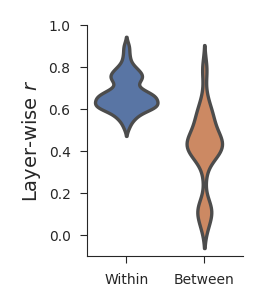

In [9]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:False.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r_within, p_within = stats.pearsonr(x['score'], x['within-concept dimensionality (mean)'])
    r_between, p_between = stats.pearsonr(x['score'], x['between-concept dimensionality'])
    return pd.DataFrame({'r_score_dim': [r_within, r_between], 'p_score_dim': [p_within, p_between], 'dim_type': ['within', 'between']})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'within-concept dimensionality (mean)', 'between-concept dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.2, 1.42))

sns.violinplot(data=data, y='r_score_dim', x='dim_type', inner=None, ax=ax)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', 
       xticklabels=['Within', 'Between'], ylim=(-.1, 1))

plt.savefig('saved/appendix_nopool-ED-vs-encoding-layerwise.png', dpi=300)
plt.show()

## By model kind

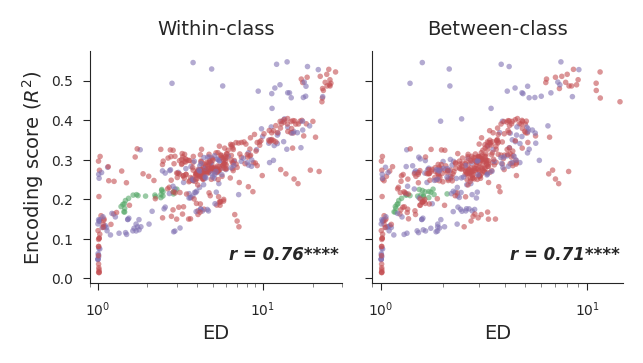

In [10]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, axs = plt.subplots(1, 2, figsize=(3.1, 1.7))

axs[0].set_xlim(0.9, 30)
sns.scatterplot(data=data, x='within-concept dimensionality (mean)', y='score',
                hue='kind', palette=sns.color_palette()[2:5],
                alpha=0.6, s=4, linewidth=0, ax=axs[0])
axs[0].set(xlabel='ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Within-class')
annotate_corr(data, x='within-concept dimensionality (mean)', y='score', pos=(0.55, 0.1), ax=axs[0])

axs[1].set_xlim(0.9, 15)
sns.scatterplot(data=data, x='between-concept dimensionality', y='score',
                hue='kind', palette=sns.color_palette()[2:5],
                alpha=0.6, s=4, linewidth=0, ax=axs[1])
axs[1].set(xlabel='ED', ylabel=None, yticklabels=[], xscale='log', title='Between-class')
annotate_corr(data, x='between-concept dimensionality', y='score', pos=(0.55, 0.1), ax=axs[1])

axs[0].legend().remove()
axs[1].legend().remove()

plt.savefig('saved/appendix_bykind-ED-vs-encoding.png', dpi=300)
plt.show()

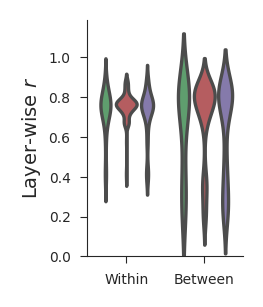

In [11]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r_within, p_within = stats.pearsonr(x['score'], x['within-concept dimensionality (mean)'])
    r_between, p_between = stats.pearsonr(x['score'], x['between-concept dimensionality'])
    return pd.DataFrame({'r_score_dim': [r_within, r_between], 'p_score_dim': [p_within, p_between], 'dim_type': ['within', 'between']})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'within-concept dimensionality (mean)', 'between-concept dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.2, 1.42))

sns.violinplot(data=data, y='r_score_dim', x='dim_type', 
               hue='kind', palette=sns.color_palette()[2:5], 
               inner=None, ax=ax)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', 
       xticklabels=['Within', 'Between'], ylim=(0, 1.19))

ax.legend().remove()

plt.savefig('saved/appendix_bykind-ED-vs-encoding-layerwise.png', dpi=300)
plt.show()

## Object2Vec

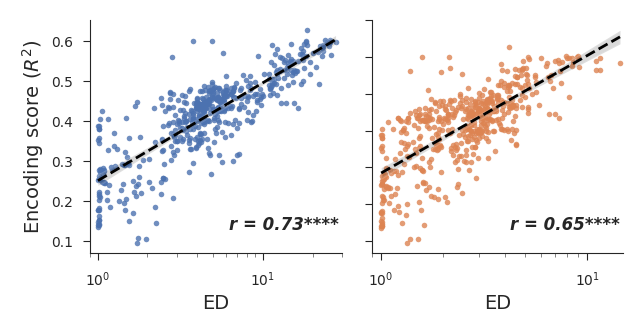

In [12]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:bonner.Object2Vec.pls.roi=LOC|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

fig, axs = plt.subplots(1, 2, figsize=(3.1, 1.55))

axs[0].set_xlim(0.9, 30)
sns.regplot(data=data, x='within-concept dimensionality (mean)', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[0])
axs[0].set(xlabel='ED', ylabel=r'Encoding score ($R^2$)', xscale='log')
annotate_corr(data, x='within-concept dimensionality (mean)', y='score', pos=(0.55, 0.1), ax=axs[0])

axs[1].set_xlim(0.9, 15)
sns.regplot(data=data, x='between-concept dimensionality', y='score', 
            logx=True, color=sns.color_palette()[1],
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=axs[1])
axs[1].set(xlabel='ED', ylabel=None, yticklabels=[], xscale='log')
annotate_corr(data, x='between-concept dimensionality', y='score', pos=(0.55, 0.1), ax=axs[1])

plt.savefig('saved/appendix_object2vec-ED-vs-encoding.png', dpi=300)
plt.show()

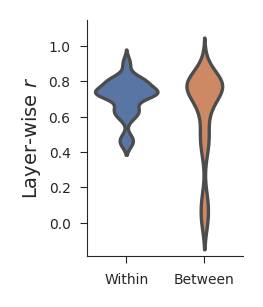

In [13]:
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results/encoding|benchmark:bonner.Object2Vec.pls.roi=LOC|pooling:False.csv'),
                pd.read_csv(f'../../results/manifolds|dataset:{dataset}|pooling:True.csv'), 
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

def corr_layer(x):
    r_within, p_within = stats.pearsonr(x['score'], x['within-concept dimensionality (mean)'])
    r_between, p_between = stats.pearsonr(x['score'], x['between-concept dimensionality'])
    return pd.DataFrame({'r_score_dim': [r_within, r_between], 'p_score_dim': [p_within, p_between], 'dim_type': ['within', 'between']})

by_layer = data.groupby(['architecture', 'layer'])[['score', 'within-concept dimensionality (mean)', 'between-concept dimensionality']]
by_layer = by_layer.apply(corr_layer).reset_index()
by_layer['significant'] = by_layer['p_score_dim'] <= 0.05
data = pd.merge(data, by_layer, on=['architecture', 'layer'], how='left')

fig, ax = plt.subplots(figsize=(1.2, 1.42))

sns.violinplot(data=data, y='r_score_dim', x='dim_type', inner=None, ax=ax)
ax.set(xlabel=None, ylabel=r'Layer-wise $r$', 
       xticklabels=['Within', 'Between'], ylim=(-.19, 1.15))

plt.savefig('saved/appendix_object2vec-ED-vs-encoding-layerwise.png', dpi=300)
plt.show()